<a href="https://colab.research.google.com/github/andersenthomas98/timeseries-forecasting/blob/main/Lag_Llama_Zero_Shot_Forecasting_Daily_Climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimenting with Lag-Llama on Daily Climate dataset

Zero shot forecasting using the motion sense dataset. The foundational model is only used (no fine-tuning) on a dataset consisting of daily averages of temperature, humidity, wind speed and pressure readings in Delhi.

Daily Climate time series data: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

Lag-Llama: https://github.com/time-series-foundation-models/lag-llama/tree/main



Clone Lag-Llama repository:

In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 178 (delta 52), reused 59 (delta 42), pack-reused 99
Receiving objects: 100% (178/178), 201.23 KiB | 1.68 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [2]:
cd lag-llama

/content/lag-llama


In [3]:
!pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

Download pretrained model weights from hugging face: https://huggingface.co/time-series-foundation-models/Lag-Llama

In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmpj9ckee_s
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 132MB/s]
/content/lag-llama/lag-llama.ckpt


Import packages, and create a prediction function

In [5]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

def get_lag_llama_predictions(dataset, prediction_length, device, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32, # Should not be changed; this is what the released Lag-Llama model was trained with

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Download daily climate time series dataset from kaggle


In [6]:
!pip install kaggle

In [8]:
from google.colab import userdata
from kaggle.api.kaggle_api_extended import KaggleApi
import os

# Setup environment variables for authenticating to kaggle using the kaggle API
kaggleUsername = userdata.get("KAGGLE_USERNAME")
kaggleKey = userdata.get("KAGGLE_KEY")
os.environ["KAGGLE_USERNAME"] = kaggleUsername
os.environ["KAGGLE_KEY"] = kaggleKey

# Authenticate
api = KaggleApi()
api.authenticate()

# Download dataset
datasetName = "sumanthvrao/daily-climate-time-series-data"
datasetPath = "/content/climate"
api.dataset_download_files(datasetName, path=datasetPath, unzip=True)



Plot climate dataset for inspection

/content/climate/DailyDelhiClimateTest.csv
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333
2017-01-06  19.318182  79.318182    8.681818   1011.772727
...               ...        ...         ...           ...
2017-04-20  34.500000  27.500000    5.562500    998.625000
2017-04-21  34.250000  39.375000    6.962500    999.875000
2017-04-22  32.900000  40.900000    8.890000   1001.600000
2017-04-23  32.875000  27.500000    9.962500   1002.125000
2017-04-24  32.000000  27.142857   12.157143   1004.142857

[113 rows x 4 columns]
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object
datetime64[ns]
First date: 2017-01-02 00:00:00
Last date

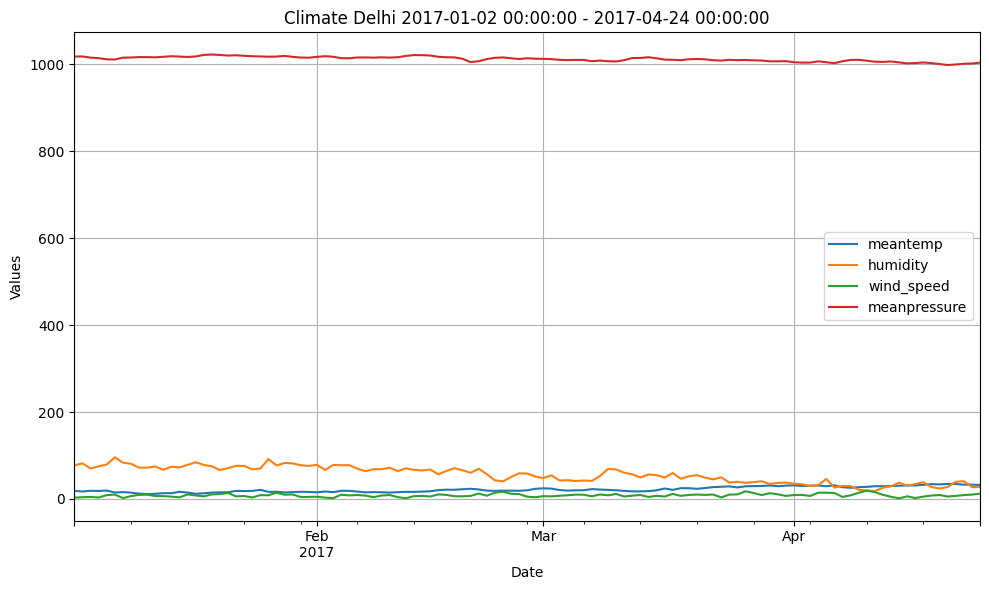

In [9]:
filePathTest = "{}/DailyDelhiClimateTest.csv".format(datasetPath)
print(filePathTest)
df = pd.read_csv(filePathTest, index_col=0, parse_dates=True)

# Remove first row as it contains in-accurate data for mean pressure
df = df.iloc[1:]

print(df)
print(df.dtypes)
print(df.index.dtype)

# Ensure all numerical columns are float32
for col in df.columns:
  if df[col].dtype != "object" and pd.api.types.is_string_dtype(df[col]) == False:
    df[col] = df[col].astype("float32")

# Get the first date
first_date = df.index.min()
print(f"First date: {first_date}")

# Get the last date
last_date = df.index.max()
print(f"Last date: {last_date}")

# Plotting all series in the DataFrame
df.plot(figsize=(10, 6))  # You can adjust the size with 'figsize'

# Customize the plot with titles, labels, etc.
plt.title('Climate Delhi {} - {}'.format(first_date, last_date))
plt.xlabel('Date')  # The label for the x-axis, which is the date here
plt.ylabel('Values')  # The label for the y-axis, which could be adjusted to fit your data
plt.legend()
plt.grid(True)  # Adds a grid for easier readability
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area

# Show the plot
plt.show()

In [14]:
# Create a PandasDataset
ds = PandasDataset(dict(df))
prediction_length = 7 # dataset has daily frequency, predict one week ahead
num_samples = 100 # number of samples sampled from the probability distribution for each timestamp
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs depending on your environment

In [15]:
# Compute predictions
forecasts, tss = get_lag_llama_predictions(ds, prediction_length, device, num_samples)


In [16]:
print("Length of forecasts: {}".format(len(forecasts)))

print("Shape of forecasts: {}".format(forecasts[0].samples.shape))

Length of forecasts: 4
Shape of forecasts: (100, 7)


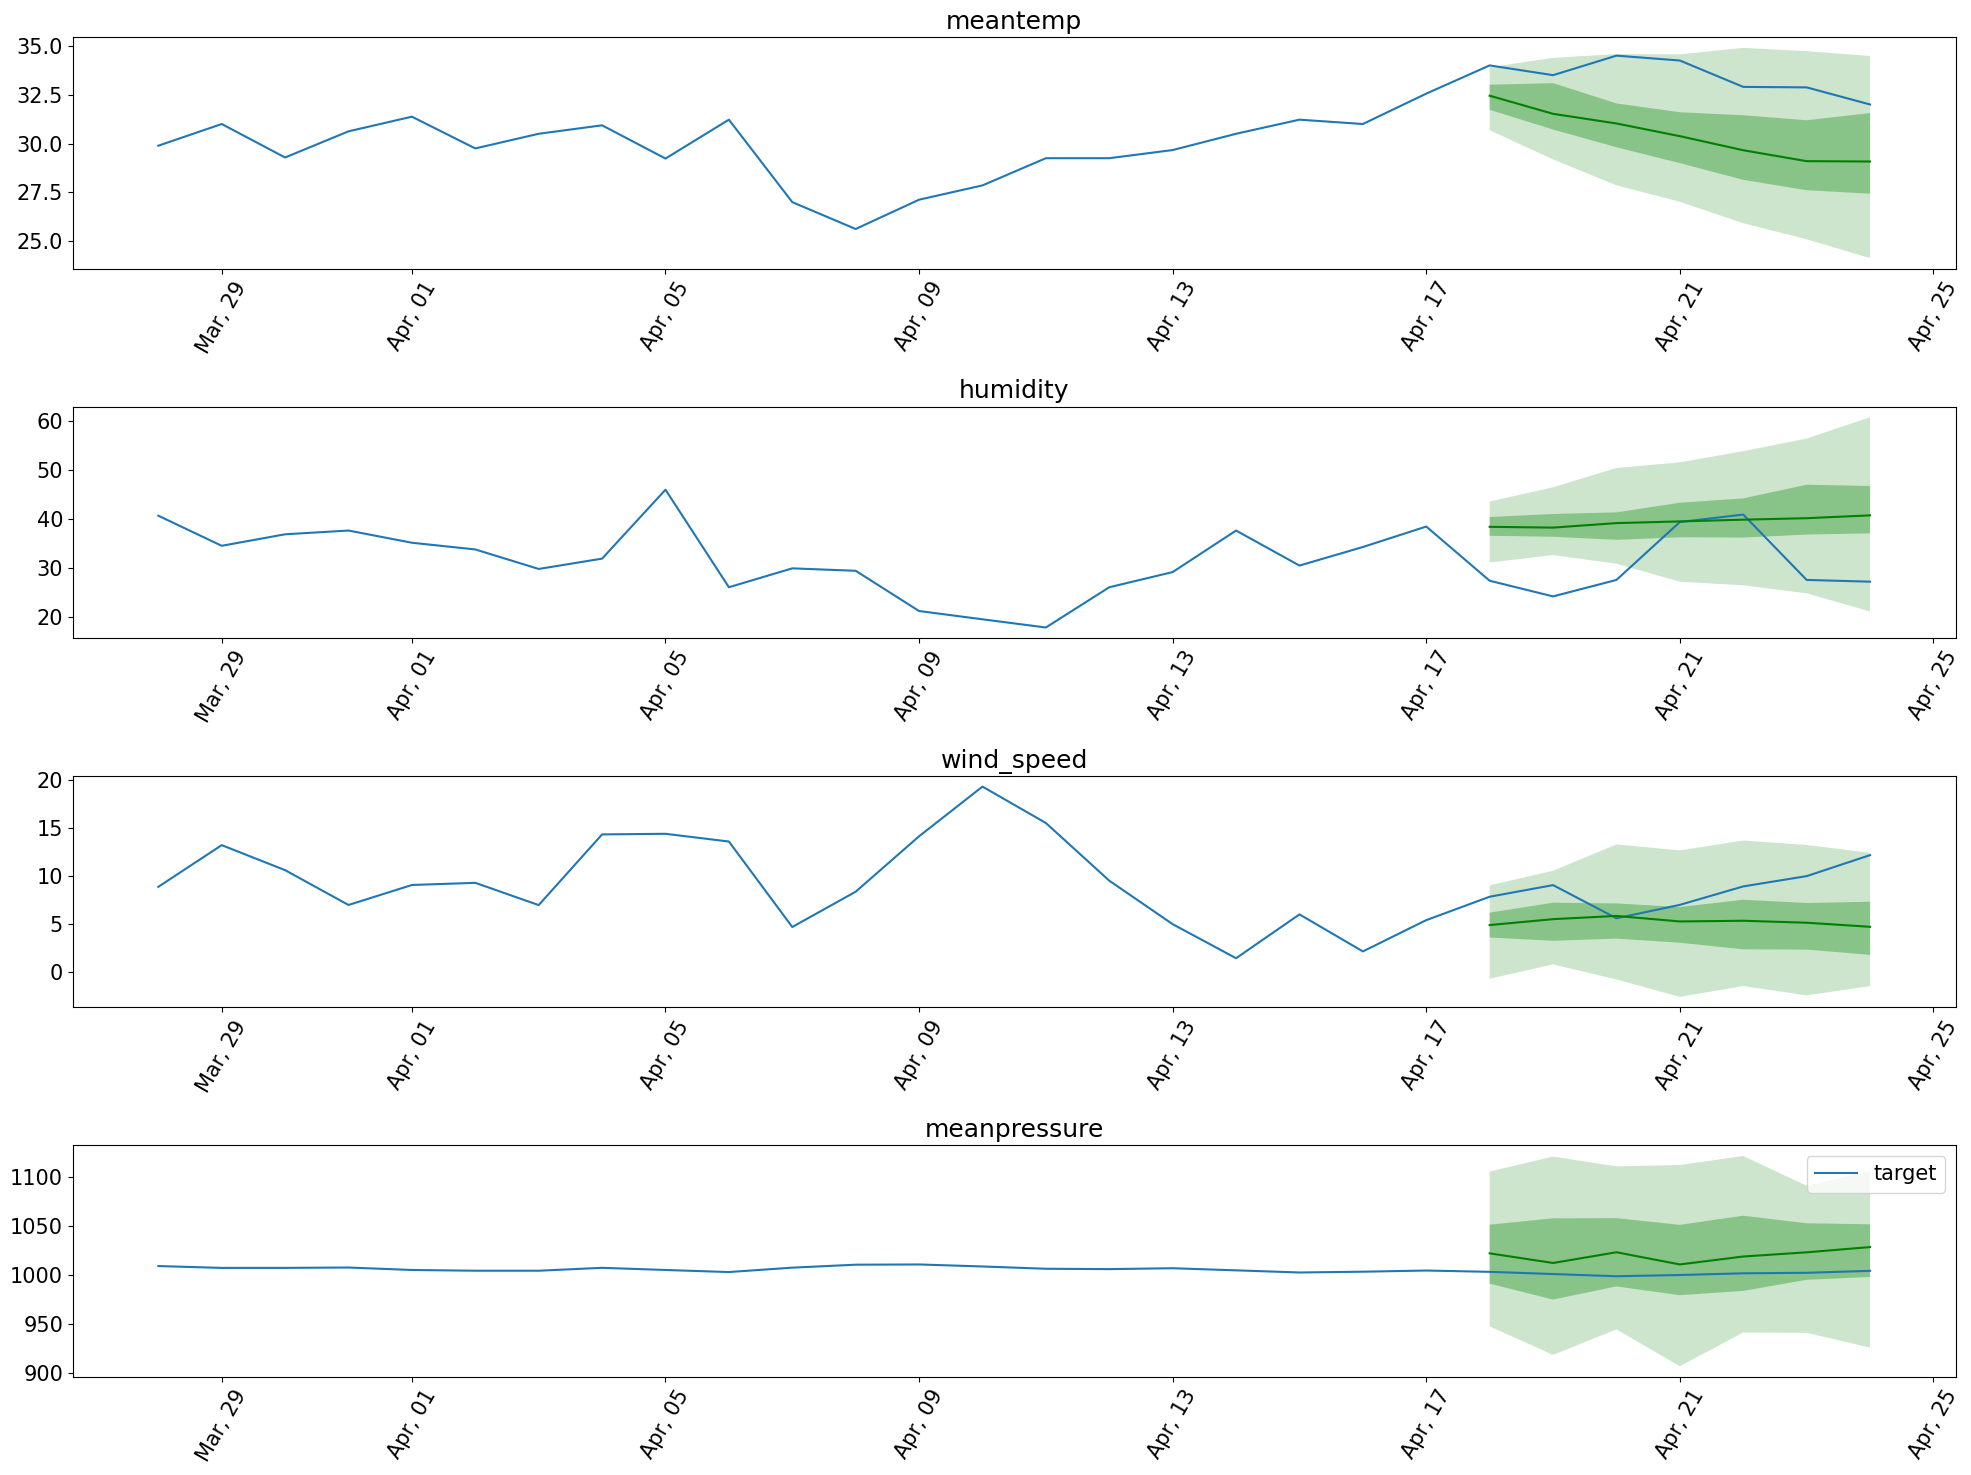

In [21]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 4 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 4):
    ax = plt.subplot(4, 1, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()